**Data Description:**
The file Bank.xls contains data on 5000 customers. The data include customer demographic information (age, income, etc.), the customer's relationship with the bank (mortgage, securities account, etc.), and the customer response to the last personal loan campaign (Personal Loan). Among these 5000 customers, only 480 (= 9.6%) accepted the personal loan that was offered to them in the earlier campaign.

**Context:**
This case is about a bank (Thera Bank) whose management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors). A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns with better target marketing to increase the success ratio with minimal budget.

**Problem Statement**

In a recent conversion campaign, 9% of liability customers converted to personal loan customers. The campaign casted a broad demographic approach and still met desired goals. 
To best serve our customers we need to develop a more targeted approach that could enhance customer satisfaction and improve conversion efficiency. 

Analytic Approach

Our dataset is imbalanced, posing unique challenges to model interpretability. I address these challenges using the following methods:

    1. Selecting the most predictive features using the variance inflation factor and feature importance rankings.

    2. Adjusting decision thresholds to enhance our model's ability to distinguish between the majority and minority classes.

    3. Using precision and recall as the preferred model evaluation statistics to balance capturing a large proportion of postive instances while minimizing false positives. 

    4. Employing ensenble learning methods to improve model performance. 

    5. Using partial dependnce plots to understand the non-linear relationships between variables. 

In [875]:
# Install libraries and packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,classification_report,  make_scorer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
from math import ceil 
from imblearn.base import FunctionSampler


**Data Preprocessing**

In [941]:
# Import data
data = pd.read_csv("/Users/charlesbryant/Library/CloudStorage/OneDrive-Personal/Machine Learning/Supervised/Project/Bank_Personal_Loan_Modelling.csv")

In [942]:
data.head(5)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [877]:
# check data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [943]:
# remove ID column
data = data.drop(["ID"],axis=1)

The ID column acts as a unique identifier and doesn't contribute analytic value. 

In [879]:
# check for missing values
data.isna().sum()

Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

No missing values in our dataset -- great! This saves us the step of imputing missing values, allowing us to move forward with other preprocessing tasks. 

In [880]:
data.describe()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


The experience column contains negative values which doesn't make sense in this context. We will transform them into positive values to ensure our data aligns with expectations. 

In [944]:
data['Experience'] = data["Experience"].abs()

In [945]:
data["CCAvg"] = data["CCAvg"].astype(float)*12

Credit card spending (CCAvg) has been converted to an annual scale, ensuring consistency with income data. 

In [947]:
data.head(5)

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,49,91107,4,19.2,1,0,0,1,0,0,0
1,45,19,34,90089,3,18.0,1,0,0,1,0,0,0
2,39,15,11,94720,1,12.0,1,0,0,0,0,0,0
3,35,9,100,94112,1,32.4,2,0,0,0,0,0,0
4,35,8,45,91330,4,12.0,2,0,0,0,0,0,1


In [946]:
data.describe()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,45.338400,20.134600,73.774200,93152.503000,2.396400,23.255256,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,11.463166,11.415189,46.033729,2121.852197,1.147663,20.971908,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,23.000000,0.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,35.000000,10.000000,39.000000,91911.000000,1.000000,8.400000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,45.000000,20.000000,64.000000,93437.000000,2.000000,18.000000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,55.000000,30.000000,98.000000,94608.000000,3.000000,30.000000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,67.000000,43.000000,224.000000,96651.000000,4.000000,120.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


Our next step in pre-processing is to remove outliers to ensure we're capturing the most relevant components. Before doing so we will visualize the correlations between variables then assess changes after outliers are removed. 

<AxesSubplot: >

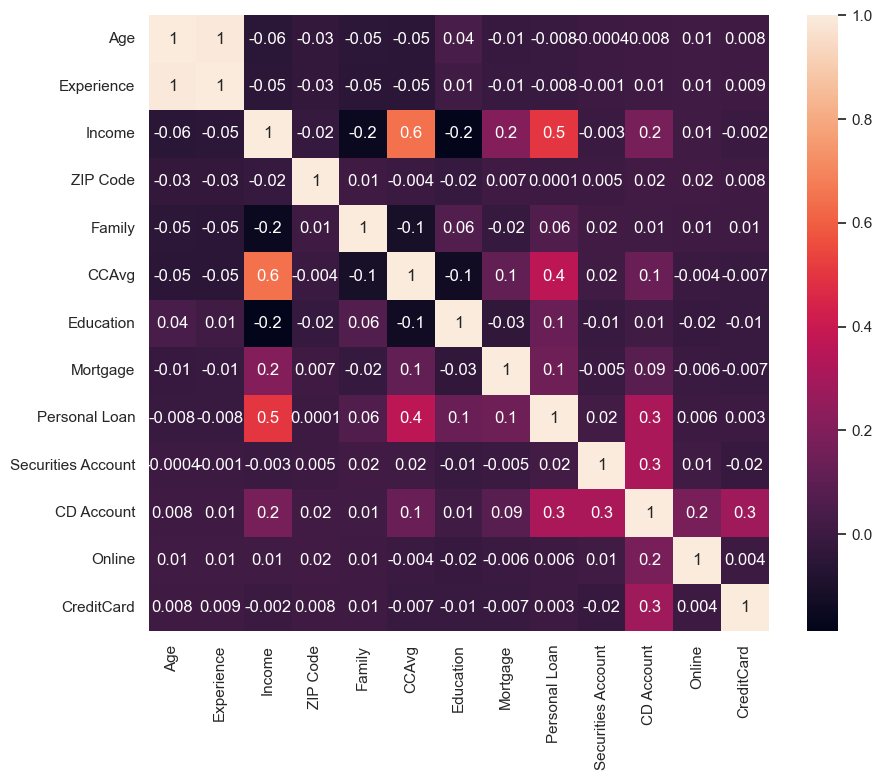

In [884]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(),annot=True,fmt='0.1g')

In [885]:
# seperate continuous and discrete features
continuous_var = ["Age","Experience","Income","CCAvg","Mortgage"]
discrete_var = ["Personal Loan","Securities Account","CD Account","Online","CreditCard","Family","Education"]

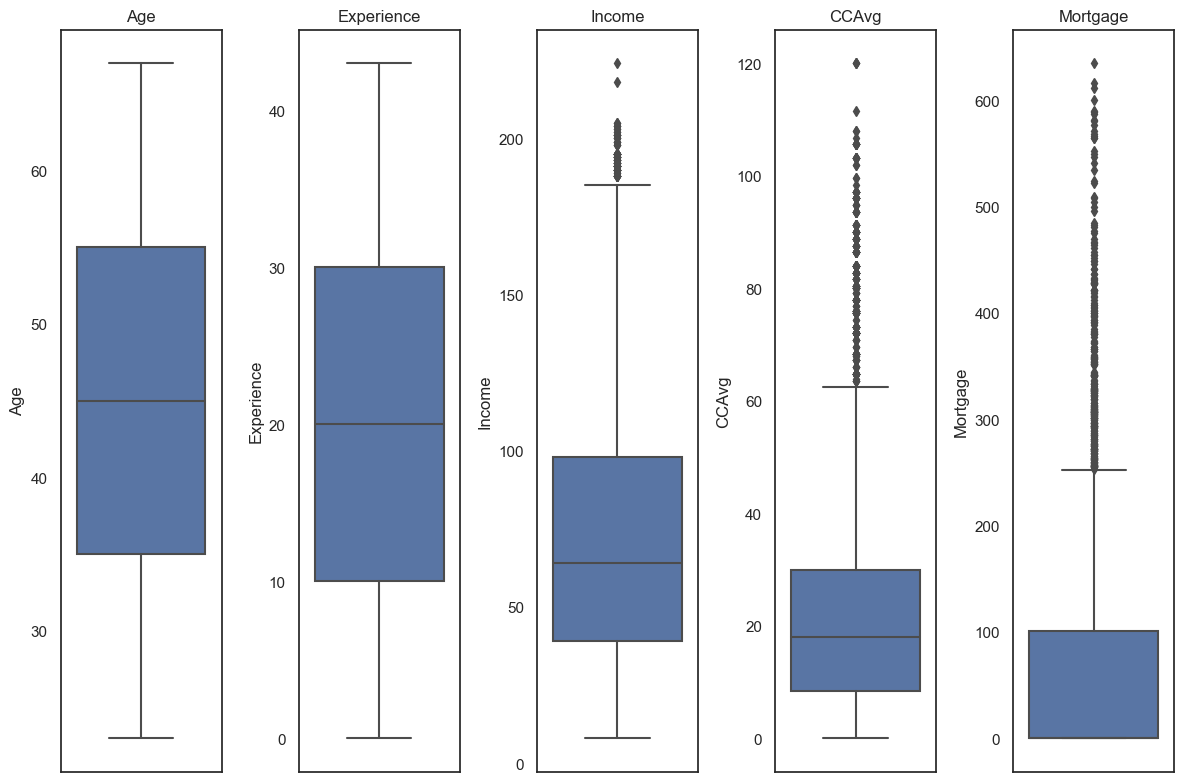

In [886]:
plt.figure(figsize=(12, 8))
for i, var in enumerate(continuous_var, 1):
    plt.subplot(1, len(continuous_var), i)
    sns.boxplot(y=data[var])
    plt.title(f"{var}")
plt.tight_layout()
plt.show()


Income, CCAvg, and Mortgage exhibit significant outliers. Using the IQR method, we will remove these outliers and analyze the summary statistics to evaluate their impact on the dataset. This approach allows us to understand how outliers influence key metrics and ensure a more reliable foundation for modeling.

In [887]:
# summary statisic of data with outliers
summary_with_outliers = data[continuous_var].describe()

# remove outliers using IQR method
data_no_outliers = data.copy()
for var in continuous_var:
    Q1 = data[var].quantile(0.25)
    Q3 = data[var].quantile(0.75)
    IQR = Q3 - Q1
    data_no_outliers = data_no_outliers[(data_no_outliers[var] >= Q1 - (1.5*IQR)) &  (data_no_outliers[var] <= Q3 + (1.5*IQR))]

summary_no_outliers = data_no_outliers[continuous_var].describe()
count_no_outliers = summary_with_outliers.loc['count'][0]
count_outliers = summary_no_outliers.loc['count'][0]
perc_outliers =(count_outliers / count_no_outliers) * 10
print("Summary with outliers")
print(summary_with_outliers)
print("Summary without outliers")
print(summary_no_outliers)
print("Percentage of outliers")
print(round(perc_outliers,2),"%")


Summary with outliers
               Age   Experience       Income        CCAvg     Mortgage
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000
mean     45.338400    20.134600    73.774200    23.255256    56.498800
std      11.463166    11.415189    46.033729    20.971908   101.713802
min      23.000000     0.000000     8.000000     0.000000     0.000000
25%      35.000000    10.000000    39.000000     8.400000     0.000000
50%      45.000000    20.000000    64.000000    18.000000     0.000000
75%      55.000000    30.000000    98.000000    30.000000   101.000000
max      67.000000    43.000000   224.000000   120.000000   635.000000
Summary without outliers
               Age   Experience       Income        CCAvg     Mortgage
count  4398.000000  4398.000000  4398.000000  4398.000000  4398.000000
mean     45.536608    20.309004    64.084584    18.613752    38.490678
std      11.490289    11.458770    38.024646    13.890412    68.108115
min      23.000000     0.00000

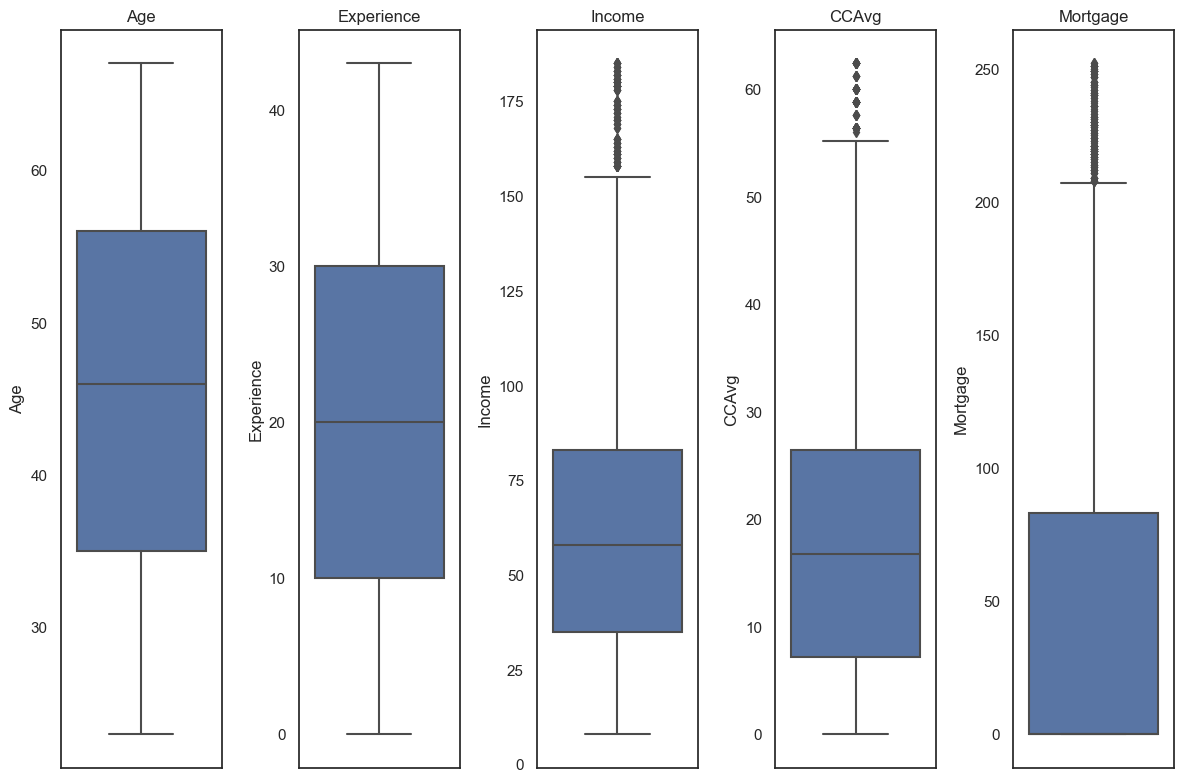

In [888]:
plt.figure(figsize=(12, 8))
for i, var in enumerate(continuous_var, 1):
    plt.subplot(1, len(continuous_var), i)
    sns.boxplot(y=data_no_outliers[var])
    plt.title(f"{var}")
plt.tight_layout()
plt.show()

Removing outliers significantly reduces the standard deviations for Mortgage, CCAvg, and Income, indicating less variability in these features. This improvement highlights a more consistent data distribution, which contributes to building a more robust and precise predictive model. Additionally, the removal of outliers decreases the maximum values of these features, aligning them more closely with typical observations and reducing the impact of extreme values.

In [889]:
# reset indices to original value so we can subset the cleaned data
data_cleaned = data.loc[data_no_outliers.index]

In [890]:
data_cleaned.describe()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000,4398.000000
mean,45.536608,20.309004,64.084584,93156.869486,2.439063,18.613752,1.922920,38.490678,0.062074,0.104366,0.047067,0.593906,0.295589
std,11.490289,11.458770,38.024646,2168.422898,1.160055,13.890412,0.835704,68.108115,0.241317,0.305769,0.211806,0.491158,0.456359
min,23.000000,0.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,10.000000,35.000000,91941.000000,1.000000,7.200000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,46.000000,20.000000,58.000000,93524.000000,2.000000,16.800000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,56.000000,30.000000,83.000000,94609.000000,4.000000,26.400000,3.000000,83.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,67.000000,43.000000,185.000000,96651.000000,4.000000,62.400000,3.000000,252.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot: xlabel='ZIP Code'>

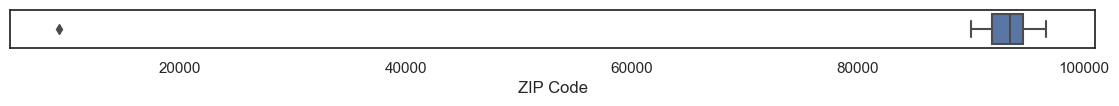

In [891]:
plt.figure(figsize=(14,0.5))
sns.boxplot(x=data_cleaned["ZIP Code"])

Zip code contains one outlier that we will remove. 

<AxesSubplot: xlabel='ZIP Code'>

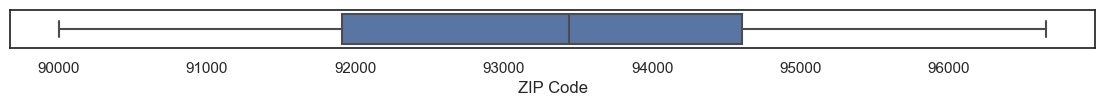

In [892]:
data = data[data["ZIP Code"] > 20000]
data.reset_index(inplace=True,drop=True)
plt.figure(figsize=(14,0.5))
sns.boxplot(x=data["ZIP Code"])

<AxesSubplot: >

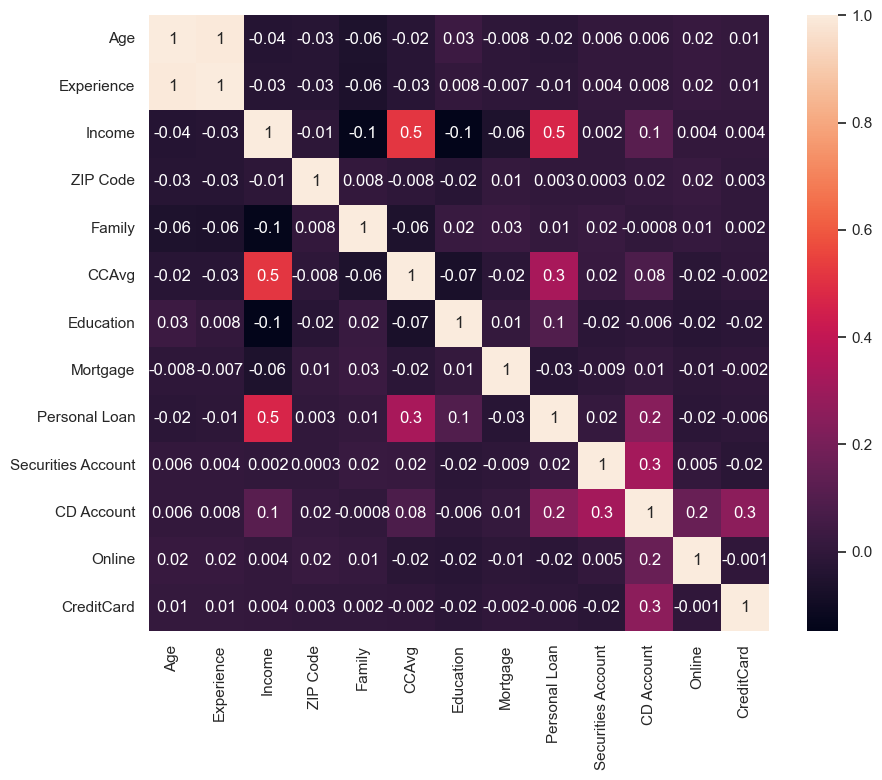

In [893]:
# plot correlation map of cleaned data
plt.figure(figsize=(10,8))
sns.heatmap(data_cleaned.corr(),annot=True,fmt='0.1g')

The correlation coefficents for Age, Experience, and Zip Code are less than 0.1, indicating that these features do not contribute to the model's predictive power. We will remove them and assess the resulting correlation output. 

In [894]:
data_cleaned = data_cleaned.drop(["Age","Experience","ZIP Code"],axis=1)

<AxesSubplot: >

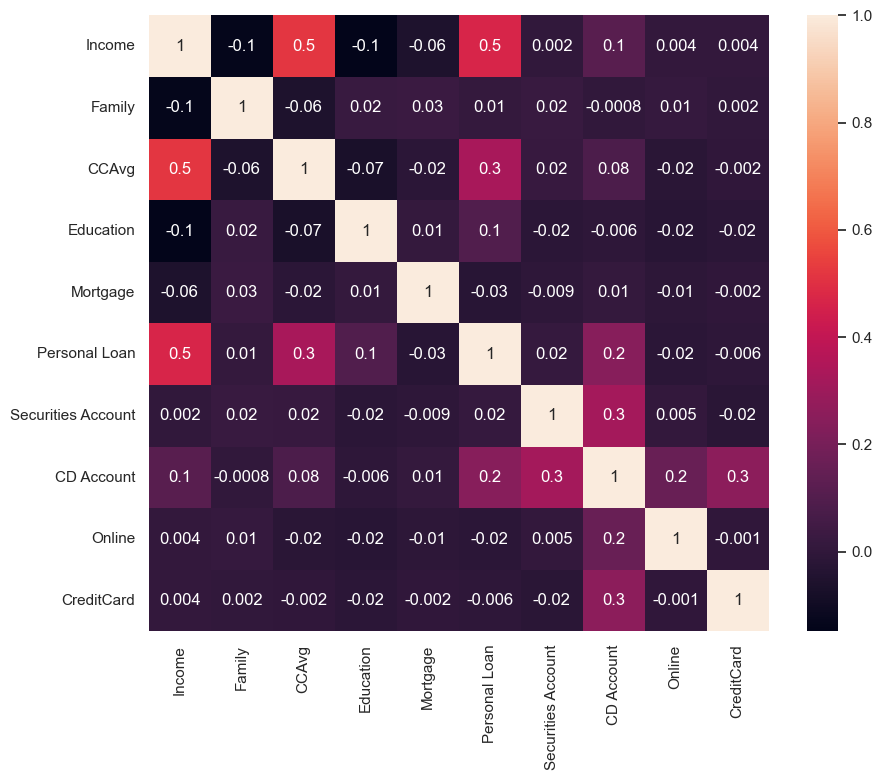

In [895]:
plt.figure(figsize=(10,8))
sns.heatmap(data_cleaned.corr(),annot=True,fmt='0.1g')

Several predictors are highly correlated, indicating potential multicollinearity. To confirm this, we will use the Variance Inflation Factor which quantifes the degree of multicollinearity among features. 

In [896]:
# Extract predictor variables
X = data_cleaned.drop("Personal Loan",axis=1)
y = data_cleaned["Personal Loan"]
# Calculate VIF for each predictor variable
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)



             Variable       VIF
0              Income  4.537039
1              Family  4.003774
2               CCAvg  3.779493
3           Education  4.121646
4            Mortgage  1.297383
5  Securities Account  1.250493
6          CD Account  1.305700
7              Online  2.307282
8          CreditCard  1.490655


Our model doesn't contain significiant multicollinearity (VIF > 10). Next, we will use a Random Forest Regressor to identify and finalize the most predictive features.

In [897]:
# instantiate model
rf_mod = RandomForestRegressor(max_depth=2, random_state=123, 
              n_estimators=100, oob_score=True)

# fit
rf_mod.fit(X, y)

columns = data_cleaned.columns # columns dataframe
feature_importances_ = rf_mod.feature_importances_ # extract feature importances

# combine columns and feature values
for col,feature in zip(columns,feature_importances_):
    feature = round(feature,2)
    print(col,feature)


Income 0.44
Family 0.0
CCAvg 0.06
Education 0.5
Mortgage 0.0
Personal Loan 0.0
Securities Account 0.0
CD Account 0.0
Online 0.0


Income, CCAvg, and Education are the most predicive features. Reducing the feature space is crucial to enhacing our model's abiility to distinguish between classes effectively. 

In [898]:
# define the dataset with final set of features
data_cleaned = data_cleaned[["Personal Loan","Income","CCAvg","Education"]]

**Data Visualization**

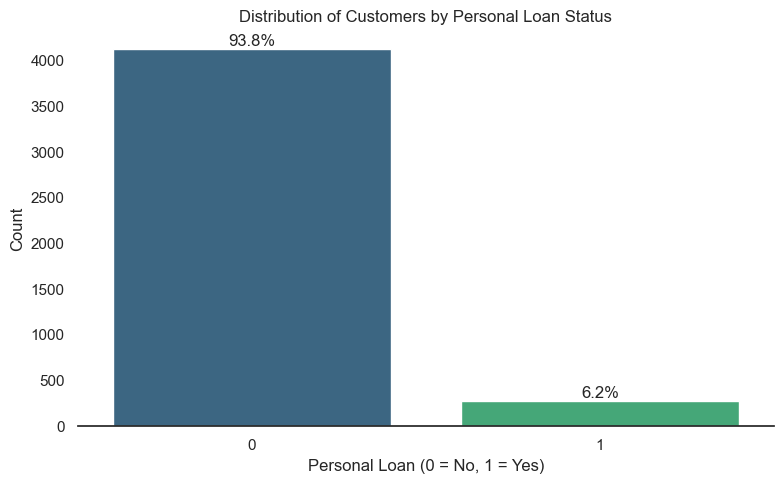

In [899]:
# Calculate the counts and percentages for "Personal Loan"
loan_counts = data_cleaned["Personal Loan"].value_counts()
loan_percentages = (loan_counts / loan_counts.sum()) * 100

# Create a figure with a single bar chart
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.set_theme(style="white")
sns.despine(top=True,right=True,left=True) # remove lines around graph
sns.barplot(x=loan_counts.index, y=loan_counts.values, ax=ax, palette="viridis")

# Annotate the percentages on top of each bar
for index, value in enumerate(loan_counts.index):
    count_value = loan_counts[value]
    percentage_value = loan_percentages[value]
    ax.text(index, count_value, f"{percentage_value:.1f}%", ha='center', va='bottom')

# Set titles and labels
ax.set_title("Distribution of Customers by Personal Loan Status")
ax.set_xlabel("Personal Loan (0 = No, 1 = Yes)")
ax.set_ylabel("Count")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


*Feature Enginnering*

Two of our most predictive values are continuous variables that can be split into bins to provide more robust analysis. Before executing we need to deal with zero values, to prevent complications when modeling. 

In [900]:
count_cczero = data_cleaned["CCAvg"] == 0
count_ccnozero = data_cleaned["CCAvg"] != 0 
proportion_cczero = round(count_cczero.sum() / count_ccnozero.sum(),2)
print("There are",count_cczero.sum(),"customers with an anuual credit spend of zero.")
print("There are", count_ccnozero.sum()," customers with an annual credit card spend greater than zero.")
print("The proportion of customers with zero annual credit card spend is", proportion_cczero,".")

There are 100 customers with an anuual credit spend of zero.
There are 4298  customers with an annual credit card spend greater than zero.
The proportion of customers with zero annual credit card spend is 0.02 .


The proportion of customers with a zero annual credit is extremely small and replacing the zero values with a small positive value will have negligible impacts on statistical calculations.

In [901]:
# Replace zero values in CCAvg with a small placeholder value
data_cleaned['CCAvg'] = data_cleaned['CCAvg'].replace(0,0.01)
print("CCAvg zero count after replacement:",(data_cleaned['CCAvg'] == 0).sum()) # ensure replacment applied correctly

CCAvg zero count after replacement: 0


In [902]:
# Create categories without labels to get numeric boundaries
temp_cut_income = pd.qcut(data_cleaned["Income"],[.0,.25,.75,.875,.9375,1])
bin_intervals_income = temp_cut_income.cat.categories # store numeric boundaries

temp_cut_CCAvg = pd.qcut(data_cleaned["CCAvg"],[.0,.25,.75,.875,.9375,1])
bin_intervals_CCAvg = temp_cut_CCAvg.cat.categories # store numeric boundaries

# Apply bins to dataframe
data_cleaned["Income Levels"] = pd.qcut(data_cleaned["Income"],[.0,.25,.75,.875,.9375,1], labels=["low","medium","high","very high","ultra high"])
data_cleaned["CCAvg Levels"] = pd.qcut(data_cleaned["CCAvg"],[.0,.25,.75,.875,.9375,1], labels=["low","medium","high","very high","ultra high"])


In [903]:
# confirm that bins were applied appropriately
data_cleaned.describe(include="all") # use include=all to display continuous and categorical variables

,Personal Loan,Income,CCAvg,Education,Income Levels,CCAvg Levels
count,4398.000000,4398.000000,4398.000000,4398.000000,4398,4398
unique,NaN,NaN,NaN,NaN,5,5
top,NaN,NaN,NaN,NaN,medium,medium
freq,NaN,NaN,NaN,NaN,2161,2191
mean,0.062074,64.084584,18.613979,1.922920,NaN,NaN
std,0.241317,38.024646,13.890108,0.835704,NaN,NaN
min,0.000000,8.000000,0.010000,1.000000,NaN,NaN
25%,0.000000,35.000000,7.200000,1.000000,NaN,NaN
50%,0.000000,58.000000,16.800000,2.000000,NaN,NaN
75%,0.000000,83.000000,26.400000,3.000000,NaN,NaN


The output above displays that 5 unique cuts were made for two categorical variables.

Summarize data across feature levels

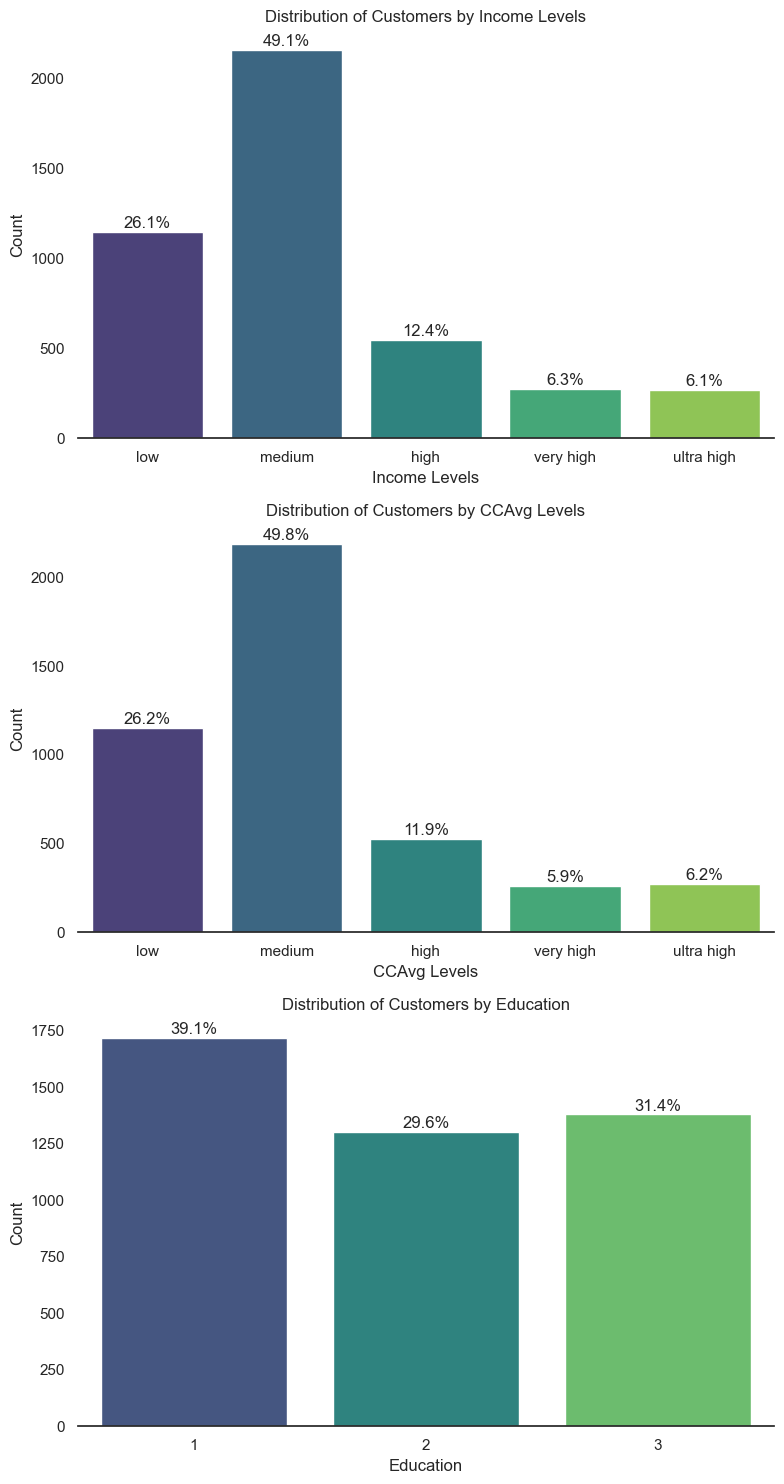

In [904]:
# List of features
variables = ["Income Levels", "CCAvg Levels", "Education"]

# Determine subplot dimensions
num_vars = len(variables)
fig, axes = plt.subplots(num_vars, 1, figsize=(8, 5 * num_vars))
sns.set_theme(style="white") # set theme

for i, var in enumerate(variables):
    # Calculate counts and percentages
    counts = data_cleaned[var].value_counts()
    percentages = (counts / counts.sum()) * 100

    # Create the bar plot
    sns.despine(top=True,right=True,left=True) # remove lines around graph
    sns.barplot(x=counts.index, y=counts.values, ax=axes[i], palette="viridis")

    # Add percentages on top of the bars
    for p in axes[i].patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / len(data_cleaned[var]))
        x = p.get_x() + p.get_width() / 2  # Center horizontally
        y = p.get_height()  # Top of the bar
        axes[i].annotate(percentage, (x, y + max(counts) * 0.0025), ha='center', va='bottom')

    # Set titles and labels
    axes[i].set_title(f"Distribution of Customers by {var}")
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("Count")

# Adjust layout
plt.tight_layout()
plt.show()


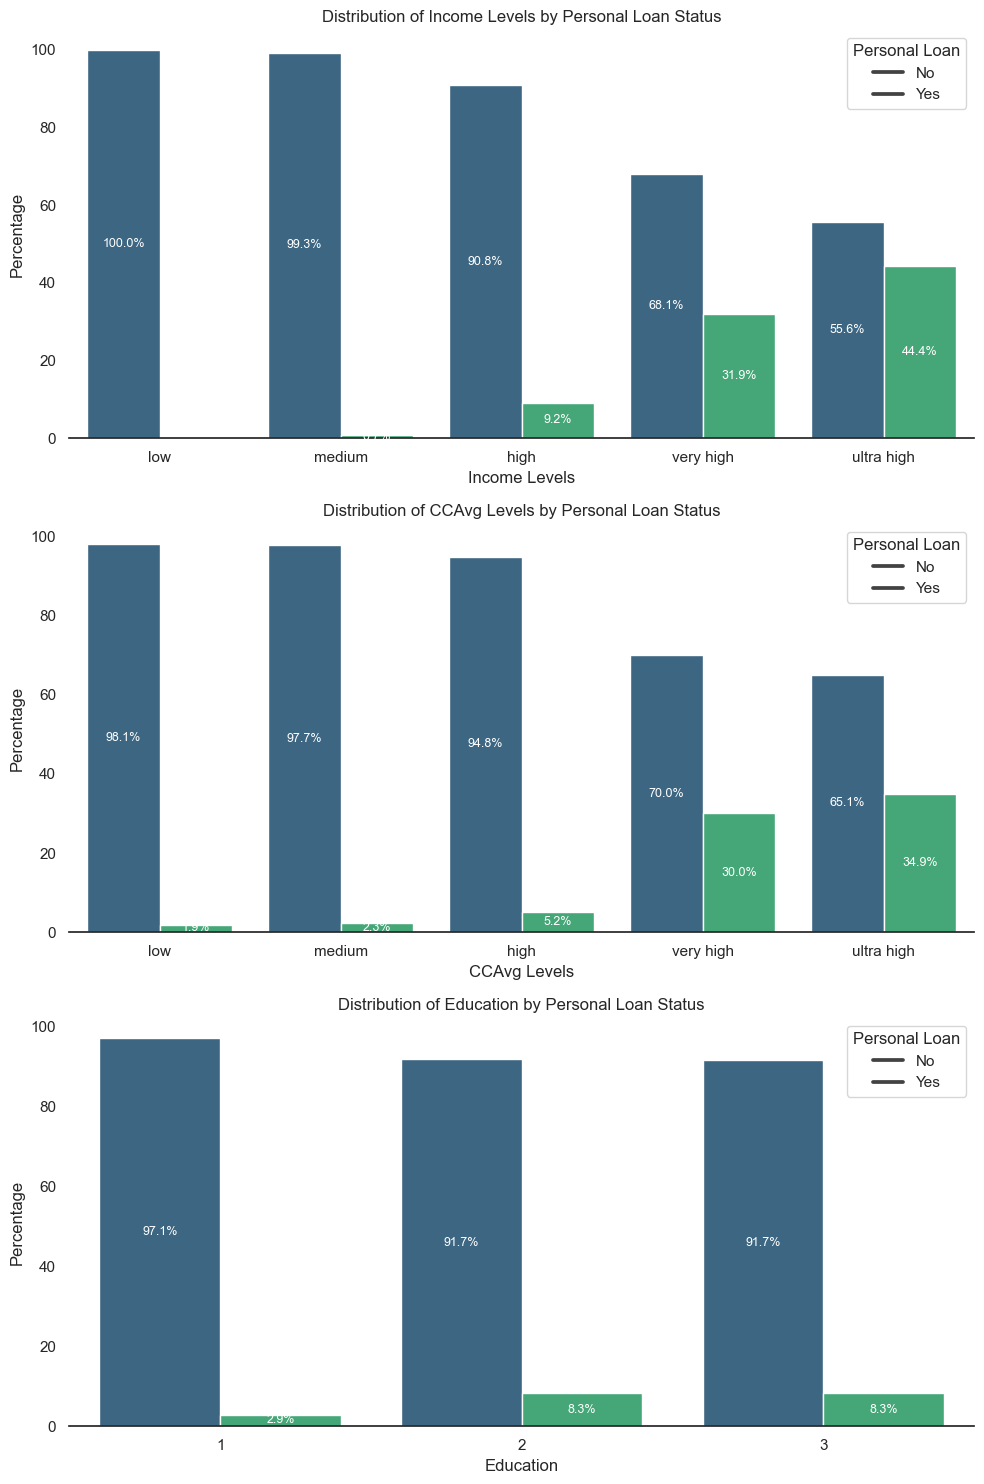

In [905]:
# List variables
variables = ["Income Levels", "CCAvg Levels", "Education"]

# Create subplots for the grouped bar charts
fig, axes = plt.subplots(len(variables), 1, figsize=(10, 5 * len(variables)))

for i, var in enumerate(variables):
    # Group by the variable and "Personal Loan" to get the count of each combination
    grouped_data = data_cleaned.groupby([var, "Personal Loan"]).size().unstack(fill_value=0)

    # Calculate percentages for each level (row-wise percentage)
    percentages = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

    # Melt the percentages data for use in Seaborn
    melted_data = percentages.reset_index().melt(id_vars=var, var_name="Personal Loan", value_name="Percentage")

    # Create the bar plot
    sns.set_theme(style="white") # set theme
    sns.barplot(
        x=var, y="Percentage", hue="Personal Loan", data=melted_data, palette="viridis", ax=axes[i]
    )

    # Remove unnecessary lines around the graph
    sns.despine(top=True, right=True, left=True, ax=axes[i])

    # Add percentages on top of each segment in the stack
    for p in axes[i].patches:
        height = p.get_height()
        if height > 0:  # Only annotate non-zero bars
            # Get the x position of the bar and annotate the percentage
            x = p.get_x() + p.get_width() / 2
            y = p.get_y() + height / 2  # Center numbers
            percentage = f'{height:.1f}%'  
            axes[i].text(x, y, percentage, ha='center', va='center', fontsize=9, color='white')

    # Set titles and labels
    axes[i].set_title(f"Distribution of {var} by Personal Loan Status")
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("Percentage")
    axes[i].legend(title="Personal Loan", labels=["No", "Yes"])

# Adjust layout
plt.tight_layout()
plt.show()


Insights:

Income Dominance: Personal loan uptake is significantly higher among individuals with very high and ultra-high income levels, as shown in income distribution and loan status plots.

Credit Card Usage: Higher CCAvg levels strongly correlate with personal loan adoption, with individuals spending more on credit cards being more likely to take loans.

To gain deeper insights, we can explore various attribute combinations. 

In [906]:
# create attribute combinations of interest
data_cleaned["Credit Spend Ratio"] = data_cleaned["Income"] / data_cleaned["CCAvg"] # Annual credit card spend as a percentage of annual income
data_cleaned["Income per Capita"] = data_cleaned["Income"] / data["Family"] # Income per family member

In [907]:
print(data_cleaned["Credit Spend Ratio"].describe())
print((data_cleaned["Credit Spend Ratio"] == np.inf).sum())  # Check for infinite values
print(data_cleaned["Credit Spend Ratio"].isnull().sum())     # Check for NaN values


count     4398.000000
mean       172.795484
std       1256.340446
min          0.666667
25%          2.205882
50%          3.281250
75%          6.333333
max      18300.000000
Name: Credit Spend Ratio, dtype: float64
0
0


In [908]:
data_cleaned.head(5) # confirm attributes

,Personal Loan,Income,CCAvg,Education,Income Levels,CCAvg Levels,Credit Spend Ratio,Income per Capita
0,0,49,19.2,1,medium,medium,2.552083,12.250000
1,0,34,18.0,1,low,medium,1.888889,11.333333
2,0,11,12.0,1,low,medium,0.916667,11.000000
3,0,100,32.4,2,high,high,3.086420,100.000000
4,0,45,12.0,2,medium,medium,3.750000,11.250000


count     4398.000000
mean       172.795484
std       1256.340446
min          0.666667
25%          2.205882
50%          3.281250
75%          6.333333
max      18300.000000
Name: Credit Spend Ratio, dtype: float64
Credit Spend Ratio contains 0 missing values


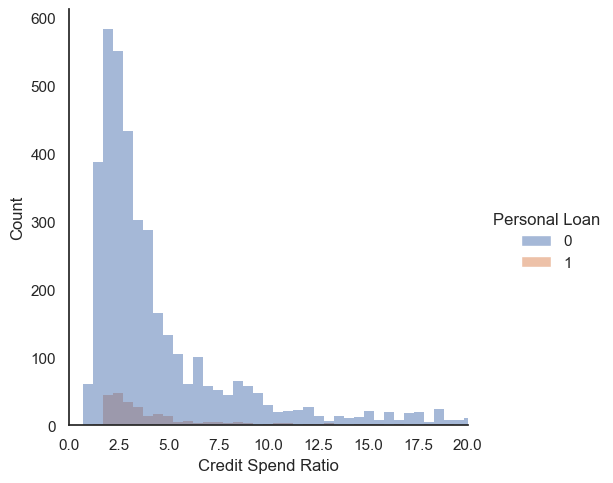

In [909]:
# Examine distribution of credit spend ratio
sns.set_theme(style="white")
sns.displot(x="Credit Spend Ratio",data=data_cleaned,hue = 'Personal Loan')
plt.xlim(0,20)
print(data_cleaned["Credit Spend Ratio"].describe())
print("Credit Spend Ratio contains", data_cleaned["Credit Spend Ratio"].isna().sum(), "missing values") # check for missing values

In [910]:
# Examine distribution of income per capita
print(data_cleaned["Income per Capita"].describe())
print("Income per Capita contains",data_cleaned["Income per Capita"].isna().sum(),"missing values")

count    4397.000000
mean       35.701691
std        31.419759
min         2.000000
25%        14.000000
50%        25.000000
75%        45.000000
max       185.000000
Name: Income per Capita, dtype: float64
Income per Capita contains 1 missing values


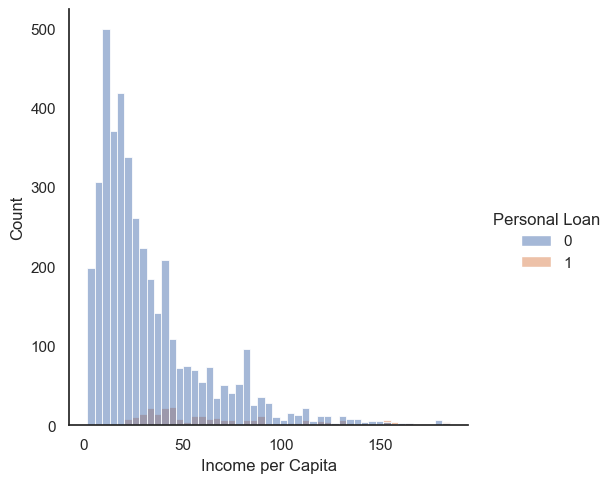

In [911]:
# replace the one missing value with a mean placeholder
data_cleaned["Income per Capita"].fillna(np.mean(data_cleaned["Income per Capita"]),inplace=True)
data_cleaned["Income per Capita"].isna().sum() # verify

# visualize distribution
sns.set_theme(style="white")
sns.displot(x="Income per Capita",data=data_cleaned,hue = 'Personal Loan')


In [912]:
data_cleaned.isna().sum()# confirm no missing values

Personal Loan         0
Income                0
CCAvg                 0
Education             0
Income Levels         0
CCAvg Levels          0
Credit Spend Ratio    0
Income per Capita     0
dtype: int64

In [913]:
# Create categories without labels to get numeric boundaries
temp_cut_creditspendratio = pd.qcut(data_cleaned["Credit Spend Ratio"],[.0,.25,.75,.875,.9375,1])
bin_intervals_creditspendration = temp_cut_creditspendratio.cat.categories # store numeric boundaries
data_cleaned["Credit Spend Ratio"] = pd.qcut(data_cleaned["Credit Spend Ratio"],[.0,.25,.75,.875,.9375,1],labels=["low","medium","high","very high","ultra high"])

temp_cut_incomepercapita= pd.qcut(data_cleaned["Income per Capita"],[.0,.25,.75,.875,.9375,1])
bin_intervals_incomepercapita = temp_cut_incomepercapita.cat.categories # store numeric boundaries
data_cleaned["Income per Capita"] = pd.qcut(data_cleaned["Income per Capita"],[.0,.25,.75,.875,.9375,1],labels=["low","medium","high","very high","ultra high"])



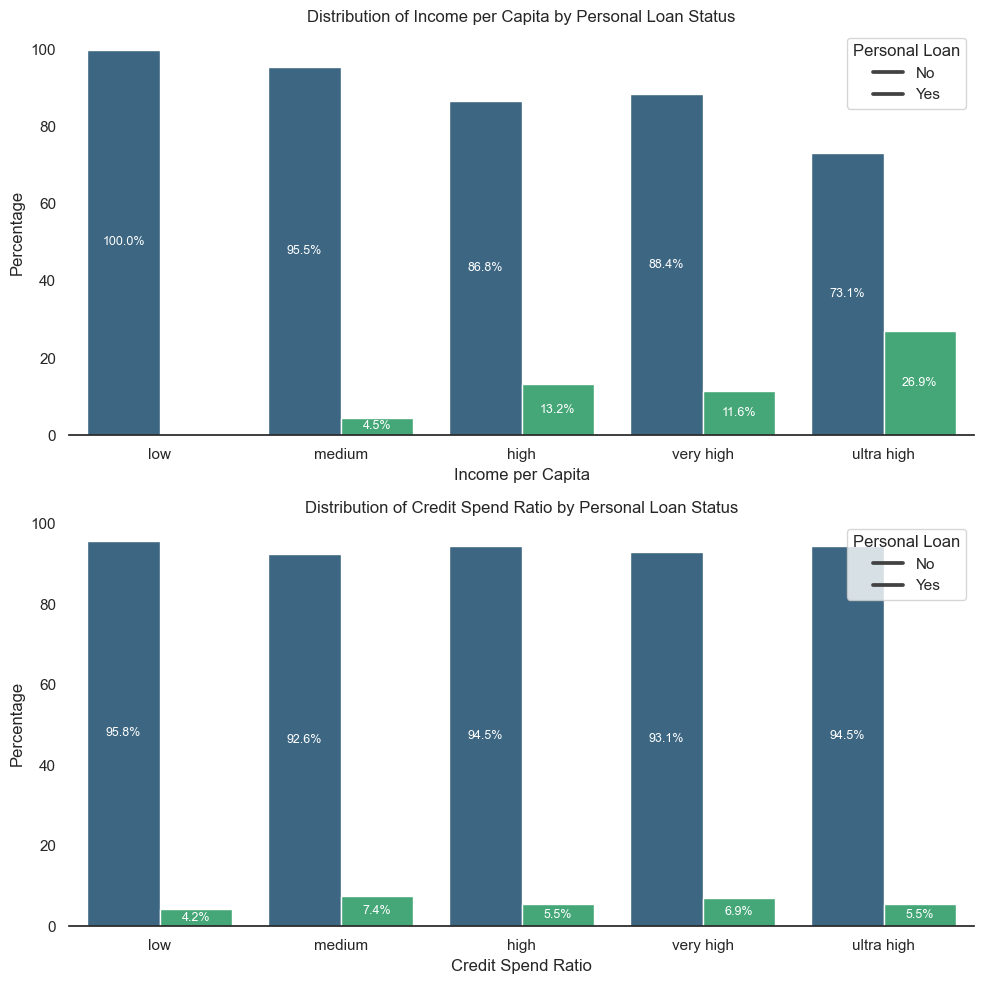

In [914]:
# Listvariables
variables = ["Income per Capita", "Credit Spend Ratio"]

# Create subplots for the grouped bar charts
fig, axes = plt.subplots(len(variables), 1, figsize=(10, 5 * len(variables)))

for i, var in enumerate(variables):
    # Group by the variable and "Personal Loan" to get the count of each combination
    grouped_data = data_cleaned.groupby([var, "Personal Loan"]).size().unstack(fill_value=0)

    # Calculate percentages for each level (row-wise percentage)
    percentages = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

    # Melt the percentages data for use in Seaborn
    melted_data = percentages.reset_index().melt(id_vars=var, var_name="Personal Loan", value_name="Percentage")

    # Create the bar plot 
    sns.set_theme(style="white") # set theme
    sns.barplot(
        x=var, y="Percentage", hue="Personal Loan", data=melted_data, palette="viridis", ax=axes[i]
    )

    # Remove unnecessary lines around the graph
    sns.despine(top=True, right=True, left=True, ax=axes[i])

    # Add percentages on top of each segment in the stack
    for p in axes[i].patches:
        height = p.get_height()
        if height > 0:  # Only annotate non-zero bars
            # Get the x position of the bar and annotate the percentage
            x = p.get_x() + p.get_width() / 2
            y = p.get_y() + height / 2  # Center numbers
            percentage = f'{height:.1f}%'  
            axes[i].text(x, y, percentage, ha='center', va='center', fontsize=9, color='white')

    # Set titles and labels
    axes[i].set_title(f"Distribution of {var} by Personal Loan Status")
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("Percentage")
    axes[i].legend(title="Personal Loan", labels=["No", "Yes"])

# Adjust layout
plt.tight_layout()
plt.show()


** Data Modeling **

Convert categorical values into numerical attributes in order to prepare data for modeling. 

In [915]:
# Fit and transform with OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
encoded_array = ordinal_encoder.fit_transform(data_cleaned.select_dtypes(include=['category', 'object']))

# Convert encoded array to DataFrame
encoded_df = pd.DataFrame(
    encoded_array,
    columns=data_cleaned.select_dtypes(include=['category', 'object']).columns,
    index=data_cleaned.index 
)

# Update original DataFrame with encoded columns
data_cleaned[encoded_df.columns] = encoded_df

# Verify the updated DataFrame
print("Updated DataFrame shape:", data_cleaned.shape)
print(data_cleaned.head())



Updated DataFrame shape: (4398, 8)
   Personal Loan  Income  CCAvg  Education  Income Levels  CCAvg Levels  \
0              0      49   19.2          1            2.0           2.0   
1              0      34   18.0          1            1.0           2.0   
2              0      11   12.0          1            1.0           2.0   
3              0     100   32.4          2            0.0           0.0   
4              0      45   12.0          2            2.0           2.0   

   Credit Spend Ratio  Income per Capita  
0                 2.0                1.0  
1                 1.0                1.0  
2                 1.0                1.0  
3                 2.0                3.0  
4                 2.0                1.0  


In [916]:
# create arrays for feature and response variables
X = data_cleaned.drop("Personal Loan",axis=1)
y = data_cleaned["Personal Loan"]
X.head()

,Income,CCAvg,Education,Income Levels,CCAvg Levels,Credit Spend Ratio,Income per Capita
0,49,19.2,1,2.0,2.0,2.0,1.0
1,34,18.0,1,1.0,2.0,1.0,1.0
2,11,12.0,1,1.0,2.0,1.0,1.0
3,100,32.4,2,0.0,0.0,2.0,3.0
4,45,12.0,2,2.0,2.0,2.0,1.0


In [917]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.30,random_state=123)

In [918]:
# confirm data split
print("X_train size:", X_train.shape)
print("X_test size:", X_test.shape)
print("y_train size:",y_train.shape)
print("y_test size:", y_test.shape)

X_train size: (3078, 7)
X_test size: (1320, 7)
y_train size: (3078,)
y_test size: (1320,)


Before modeling, we need to ensure that the distribution of the training and testing data aligns with the overall distribuition of our data set. 

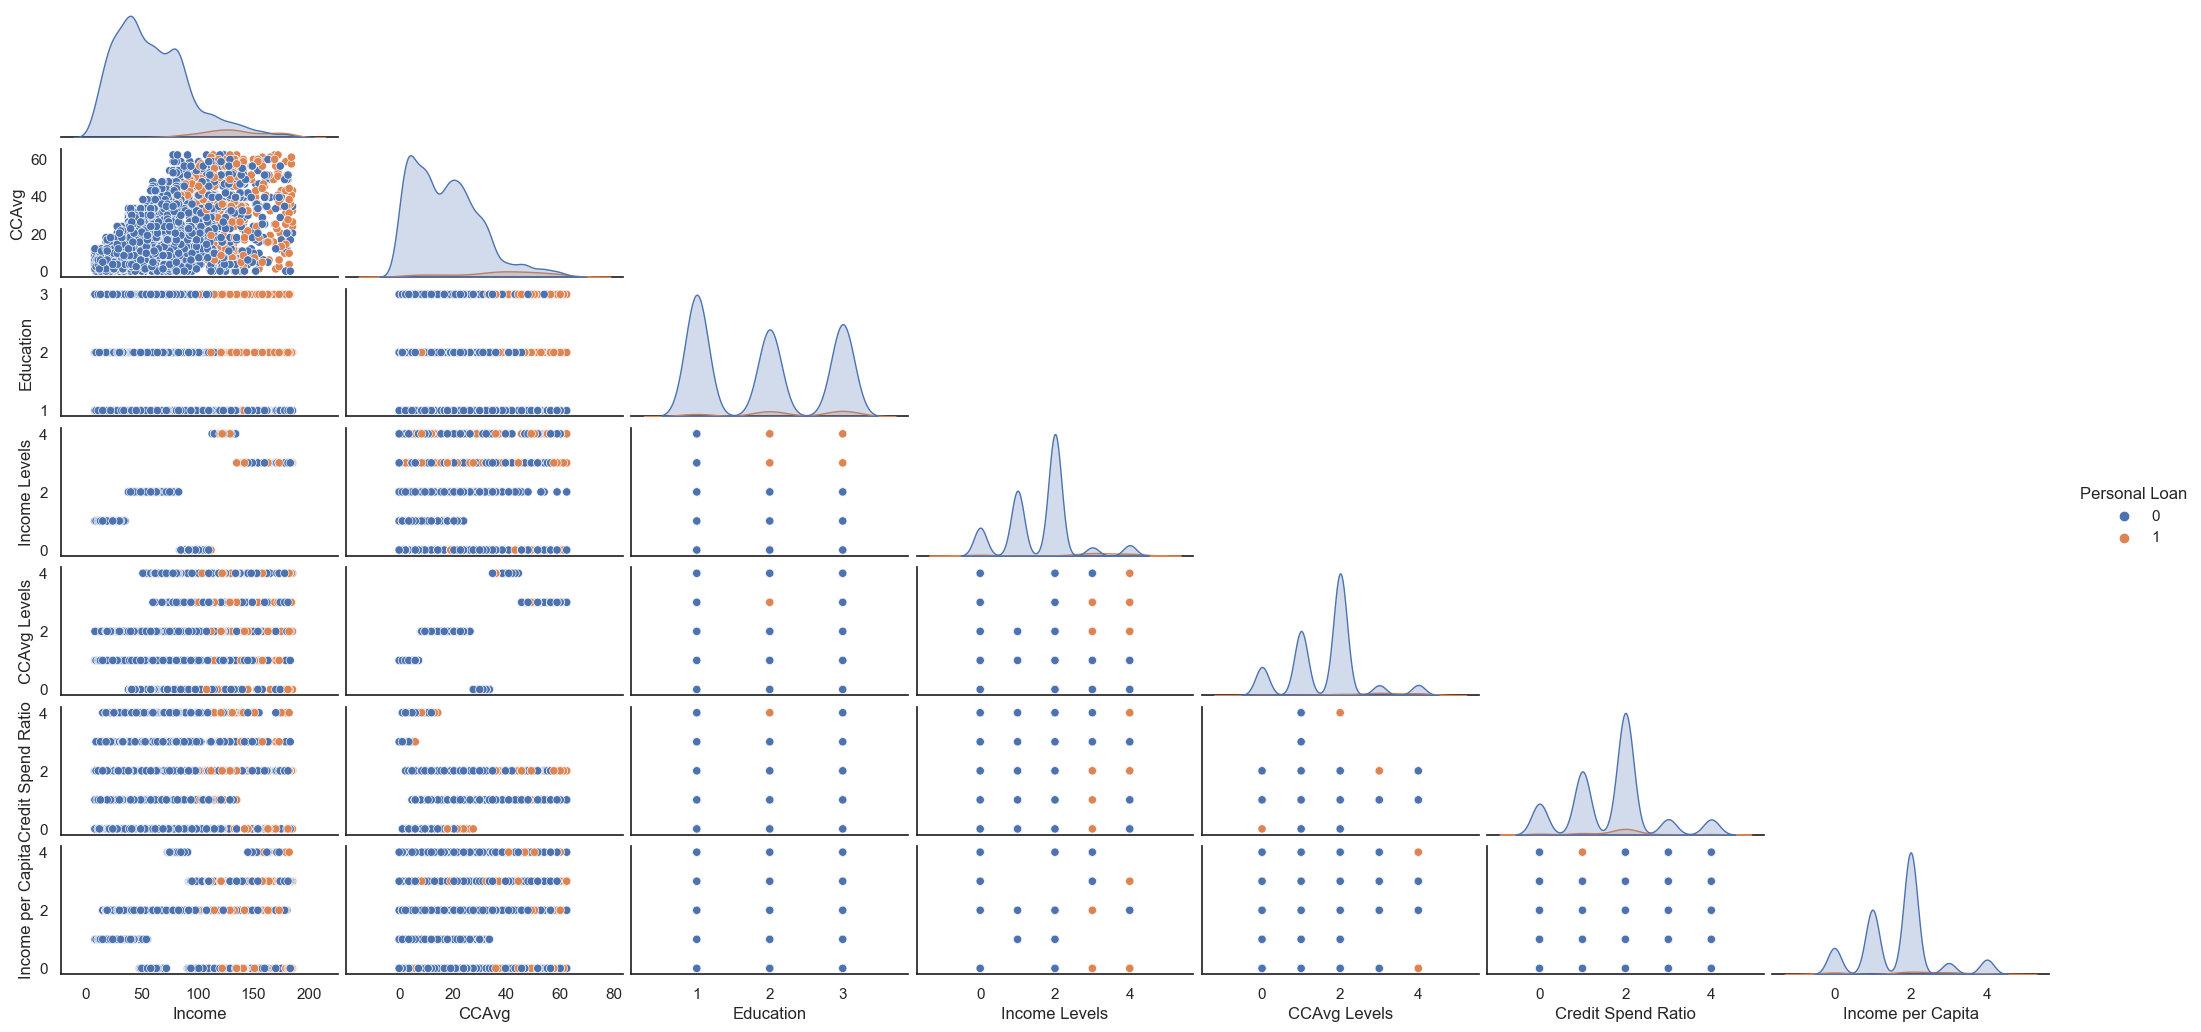

In [919]:
sns.pairplot(data_cleaned,height=1.5,aspect=2.0,corner=True,hue = "Personal Loan") # pairplot for entire dataset
plt.show()

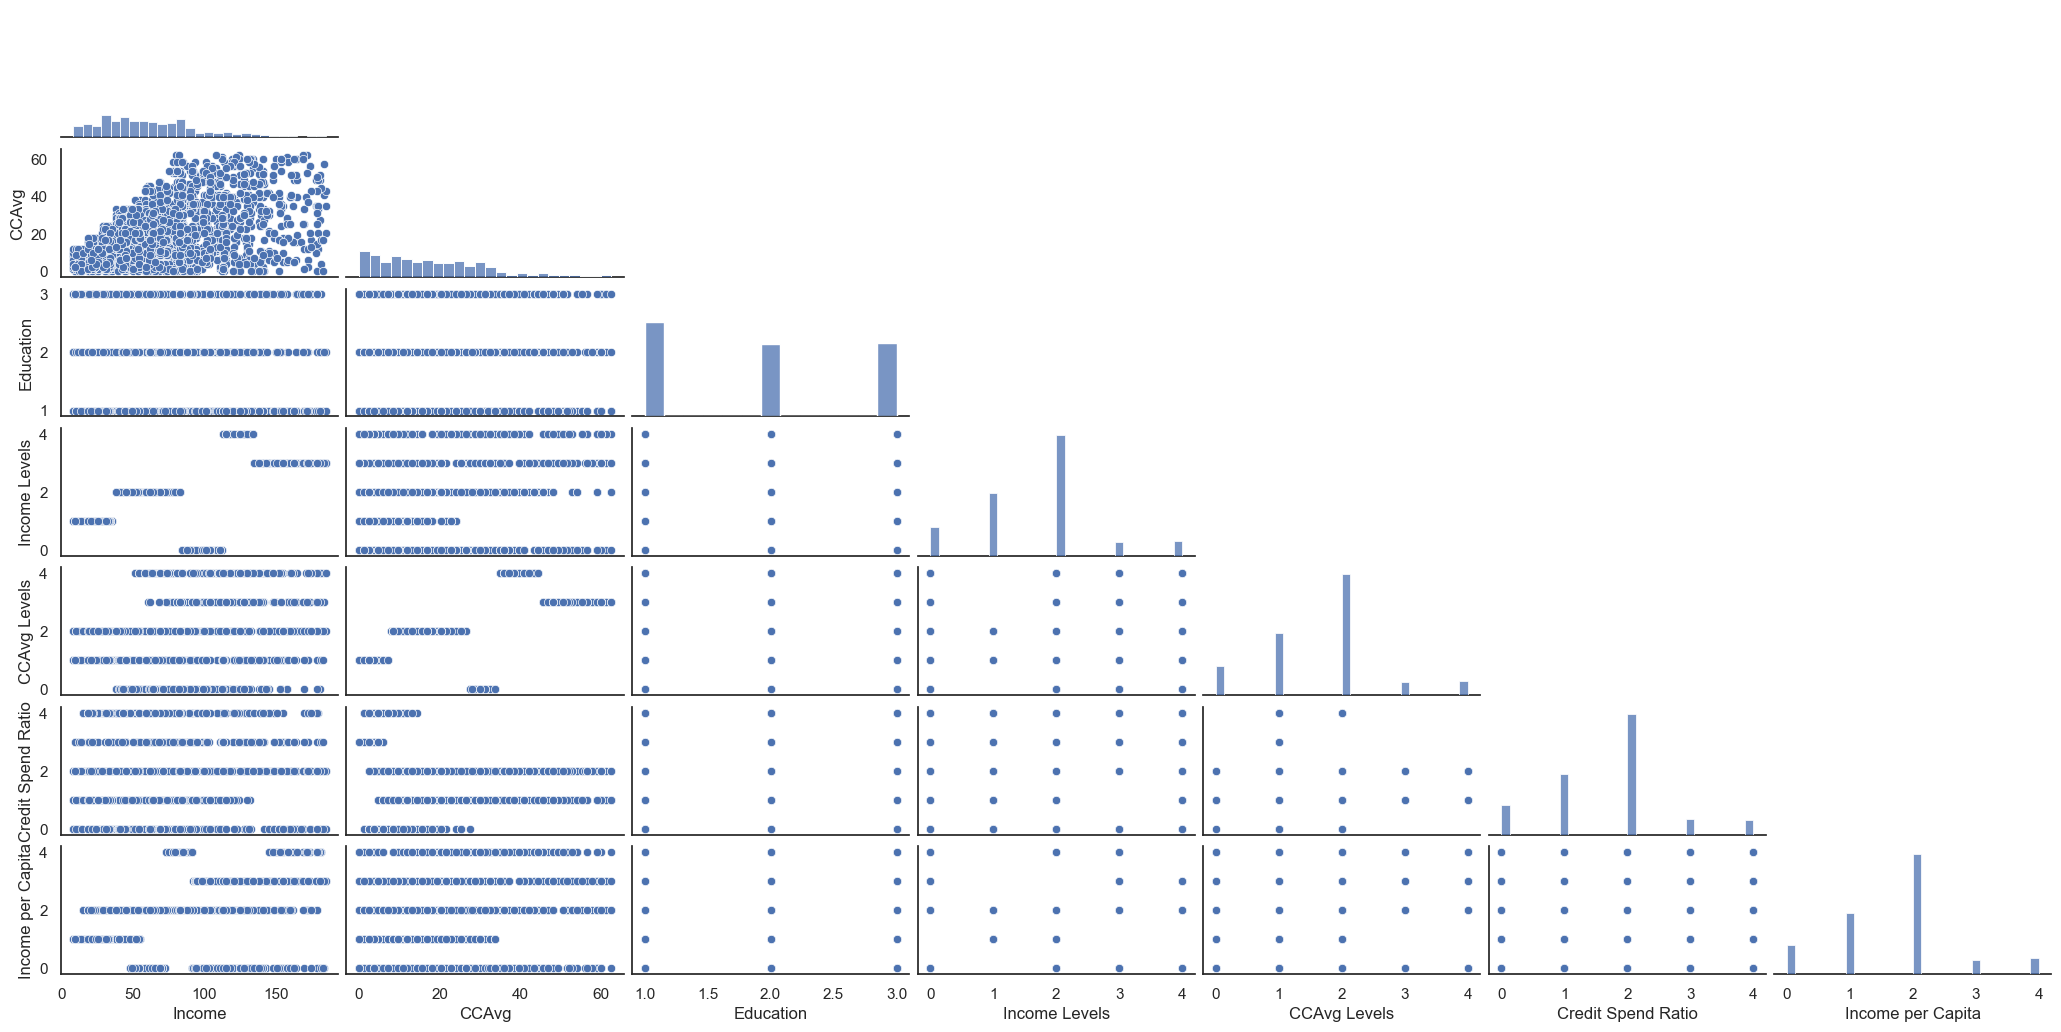

In [920]:
sns.pairplot(X_train,height=1.5,aspect=2.0,corner=True) # pairplot for X_train
plt.show()

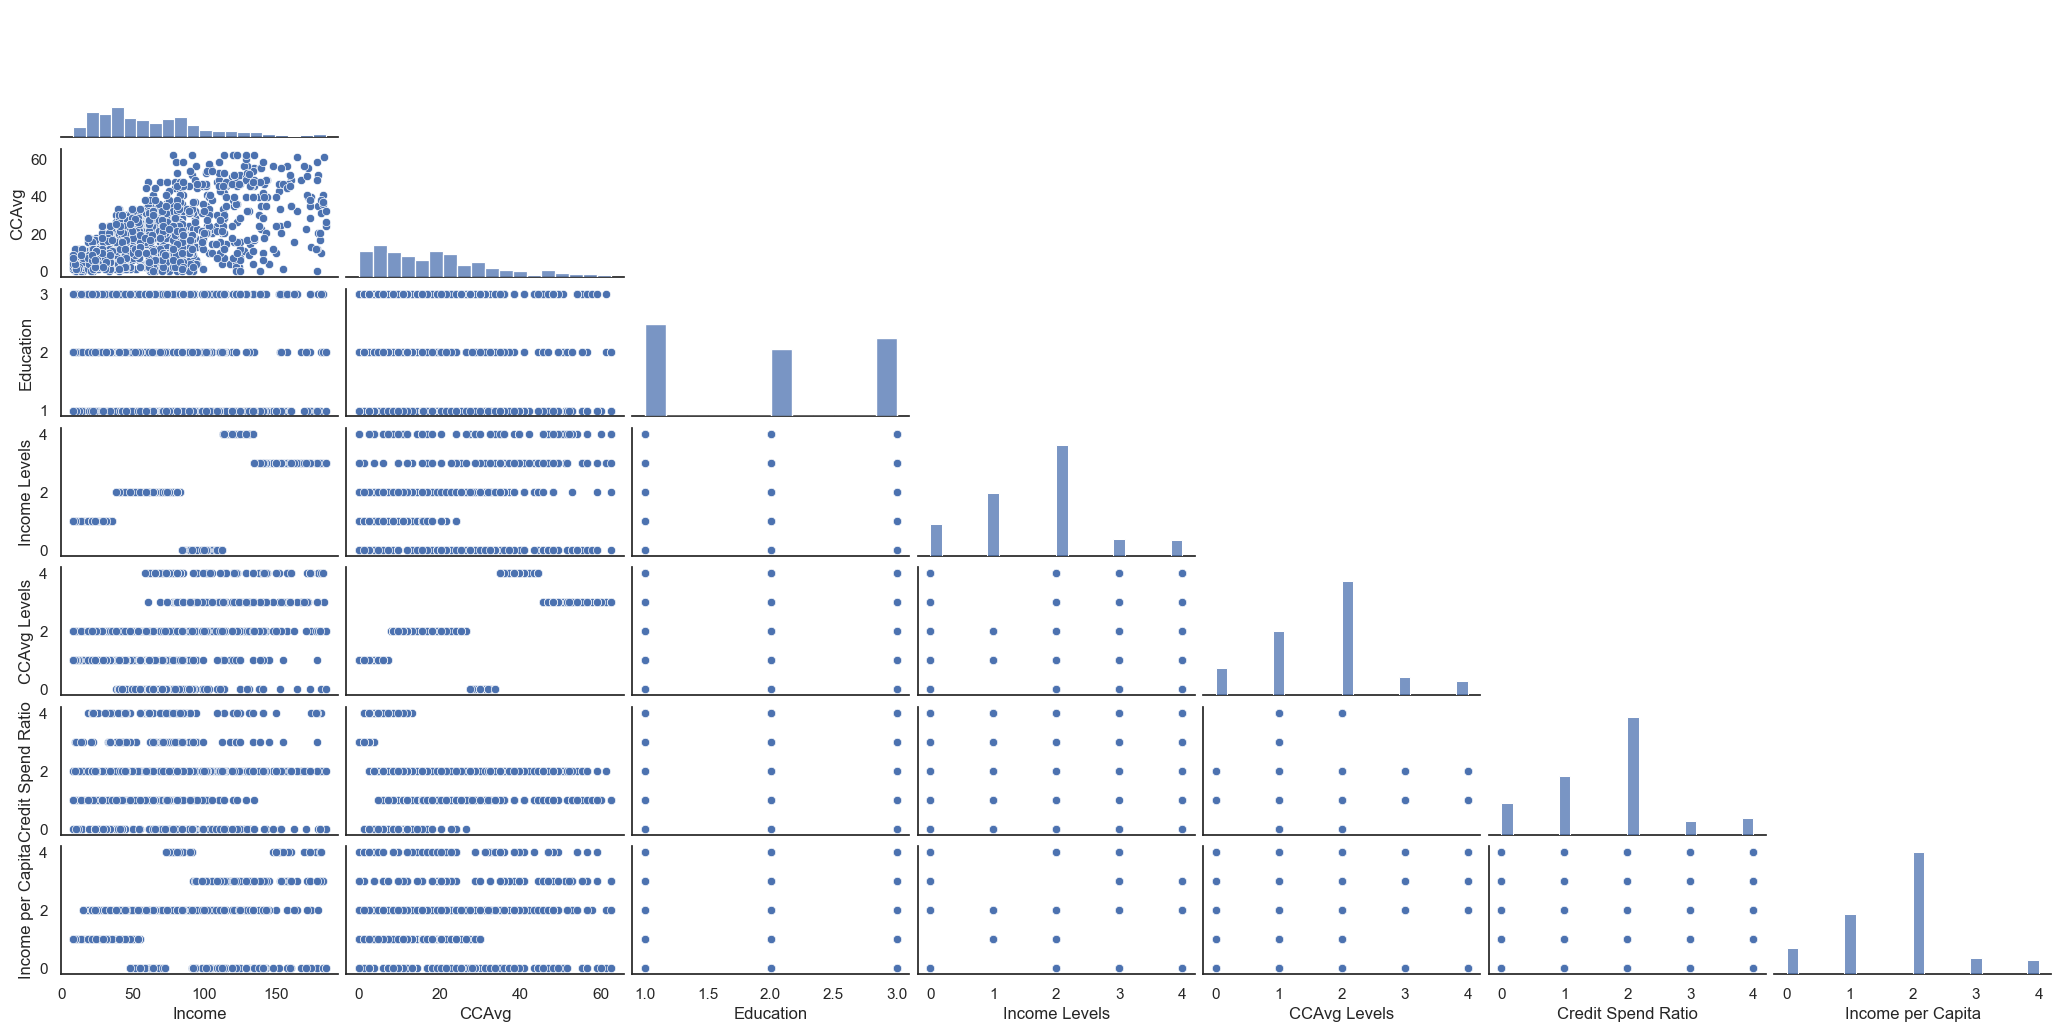

In [921]:
sns.pairplot(X_test,height=1.5,aspect=2.0,corner=True) # pairplot for X_test
plt.show()

In [922]:
print(X_train.describe())

            Income        CCAvg    Education  Income Levels  CCAvg Levels  \
count  3078.000000  3078.000000  3078.000000    3078.000000   3078.000000   
mean     63.615660    18.507031     1.913580       1.678363      1.669916   
std      37.336842    13.717615     0.831812       0.967052      0.962176   
min       8.000000     0.010000     1.000000       0.000000      0.000000   
25%      35.000000     7.200000     1.000000       1.000000      1.000000   
50%      58.000000    16.800000     2.000000       2.000000      2.000000   
75%      83.000000    26.400000     3.000000       2.000000      2.000000   
max     185.000000    62.400000     3.000000       4.000000      4.000000   

       Credit Spend Ratio  Income per Capita  
count         3078.000000        3078.000000  
mean             1.686810           1.691033  
std              0.972499           0.987601  
min              0.000000           0.000000  
25%              1.000000           1.000000  
50%              2.00000

The distribution of training and testing data aligns with the overall distribution of the dataset. We are now prepared to model our data. 

In [923]:
# instantiate model
lr = LogisticRegression(max_iter=1000,class_weight='balanced') # balance class weights
# fit
model  = lr.fit(X_train,y_train)
# predict and print accuracy
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
print(accuracy_score(y_test,y_pred))

0.8924242424242425


In [924]:
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      1220
           1       0.41      0.94      0.57       100

    accuracy                           0.89      1320
   macro avg       0.70      0.91      0.75      1320
weighted avg       0.95      0.89      0.91      1320



Our goal is to predict which customers are most likely to accept personal loans, with a focus on optimizing both recall and precision for positive predictions. Looking at the classification report, the model shows some promising results but also areas for improvement. For the positive class, the recall is very high at 0.94, which means the model is effective at identifying customers who are likely to accept a loan. However, the precision for this class is quite low at 0.41, indicating a high rate of false positives. In contrast, the model performs exceptionally well for the negative class, with precision at 0.99 and recall at 0.89, which shows it reliably identifies customers unlikely to accept loans.

While the overall accuracy of the model is 0.89, the imbalance between recall and precision for the positive class is an area that needs attention. To address this, the next step will be to use a precision-recall curve to identify an optimal decision threshold. By fine-tuning the threshold, we can aim to balance precision and recall for the positive class more effectively, reducing false positives while maintaining strong recall. This step is critical for aligning model performance with the business goal of accurately identifying customers likely to accept loans without overestimating.

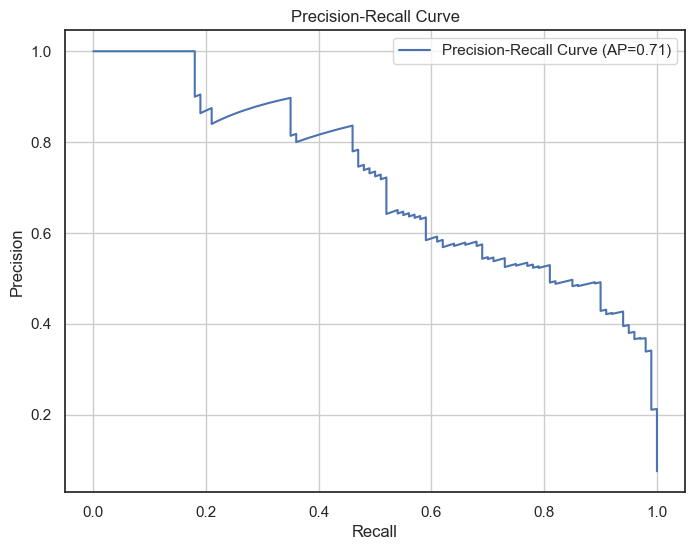

The optimal threshold is: 0.793


In [925]:
# Extract the positive class probabilities
y_pred_proba_positive = y_pred_proba[:, 1]
precision,recall,thresholds = precision_recall_curve(y_test,y_pred_proba_positive)
avg_precision = average_precision_score(y_test,y_pred_proba_positive)
# Compute F1-Score for each threshold
f1_scores = [2 * (p * r) / (p + r) for p, r in zip(precision[:-1], recall[:-1])]
best_index = np.argmax(f1_scores) # optimize for f1 score(balances precision and recall)
best_threshold = thresholds[best_index] # selcect best threshold

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AP={avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

print(f"The optimal threshold is:", round(best_threshold,3))

In [926]:
model  = lr.fit(X_train,y_train)
# predict and print accuracy
y_pred_custom = (model.predict_proba(X_test)[:, 1] >= 0.793).astype(int) 
print(accuracy_score(y_test,y_pred_custom))

report = classification_report(y_test,y_pred_custom)
print(report)

0.931060606060606
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1220
           1       0.53      0.81      0.64       100

    accuracy                           0.93      1320
   macro avg       0.76      0.88      0.80      1320
weighted avg       0.95      0.93      0.94      1320



Adjusting the decision threshold improves the balance between precision and recall for the minority class, but the model still struggles to differentiate between classes effectively. To address this, we will incorporate SMOTE, an oversampling technique that generates synthetic data points for the minority class, aiming to improve class balance and overall model performance.

In [927]:
# Define pipeline with SMOTE and logistic regression
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(max_iter=5000, class_weight='balanced'))
])

# Define parameter grid for both SMOTE and logistic regression
param_grid = {
    'smote__sampling_strategy': [0.2,0.3,0.4,0.5,0.6,0.7,0.9],  # Proportion of minority to majority
    'smote__k_neighbors': [3, 5, 7,9],              # Number of neighbors for SMOTE
    'logreg__C': [0.01, 0.1, 1, 10, 100],          # Regularization strength
    'logreg__penalty': ['l2'],                     
    'logreg__solver': ['liblinear', 'saga','lbfgs'],  
}

# Define F1 scorer for the positive class (our focus is on positive predictions)
f1_positive_scorer = make_scorer(f1_score, pos_label=1)

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=50,               # Number of parameter combination
    scoring=f1_positive_scorer,  # Optimize for F1-score of the positive class
    cv=5,                    # 5-fold cross-validation
    random_state=42,
    n_jobs=-1                # Use all available CPU cores
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best parameters and F1-score
print("Best Parameters:", random_search.best_params_)
print("Best F1-Score on Positive Class:", random_search.best_score_)

best_model = random_search.best_estimator_
#Evaluate on the test set
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))


413327.24s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
413327.24s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
413327.26s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
413327.28s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
413327.29s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
413327.30s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
413327.31s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
413327.33s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/

Best Parameters: {'smote__sampling_strategy': 0.2, 'smote__k_neighbors': 5, 'logreg__solver': 'lbfgs', 'logreg__penalty': 'l2', 'logreg__C': 1}
Best F1-Score on Positive Class: 0.4965359658928229
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1220
           1       0.40      0.95      0.57       100

    accuracy                           0.89      1320
   macro avg       0.70      0.92      0.75      1320
weighted avg       0.95      0.89      0.91      1320



Our model continues to struggle with class differentiation. To address this, we will explore Random Forests, which train multiple models independently on varied feature sets and data samples. This diversity helps reduce model variance and may improve overall performance.

In [928]:
# Wrap SMOTE as a transformer
def smote_resampler(X, y):
    smote = SMOTE(random_state=42, sampling_strategy=1.0)
    return smote.fit_resample(X, y)

smote_transformer = FunctionSampler(func=smote_resampler)

# Define the pipeline
pipeline = Pipeline([
    ('smote', smote_transformer),  # Use the wrapped SMOTE
    ('rf', RandomForestClassifier(class_weight={0: 1, 1: 2}, random_state=42))  # Define RF Classifier & adjust class weights 
])


# Define the parameter grid
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [5, 10, 15],
    'rf__min_samples_split': [5, 10],
    'rf__min_samples_leaf': [2, 5, 10],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__class_weight': ['balanced', 'balanced_subsample']
}

# Define  RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=20,  
    scoring='f1',  # use f1 as scoring preference to balance precision and recall 
    cv=3,
    n_jobs=-1,
    random_state=42
)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best F1-Score on Positive Class:", random_search.best_score_)

# Get the best model
best_model = random_search.best_estimator_

# Predict probabilities for the positive class
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# default threshold resulted in f1_score of 82 for the positive class with .83 recall and .81 precision
# I applied manual adjustments to optimze recall and precision

optimal_threshold = 0.525

# Apply the threshold to generate predictions
y_pred_custom = (y_pred_proba >= optimal_threshold).astype(int)

# Evaluate the performance using the custom threshold
print(classification_report(y_test, y_pred_custom))




Best Parameters: {'rf__n_estimators': 200, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 2, 'rf__max_features': 'sqrt', 'rf__max_depth': 15, 'rf__class_weight': 'balanced'}
Best F1-Score on Positive Class: 0.7410940305697893
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1220
           1       0.83      0.82      0.82       100

    accuracy                           0.97      1320
   macro avg       0.91      0.90      0.90      1320
weighted avg       0.97      0.97      0.97      1320



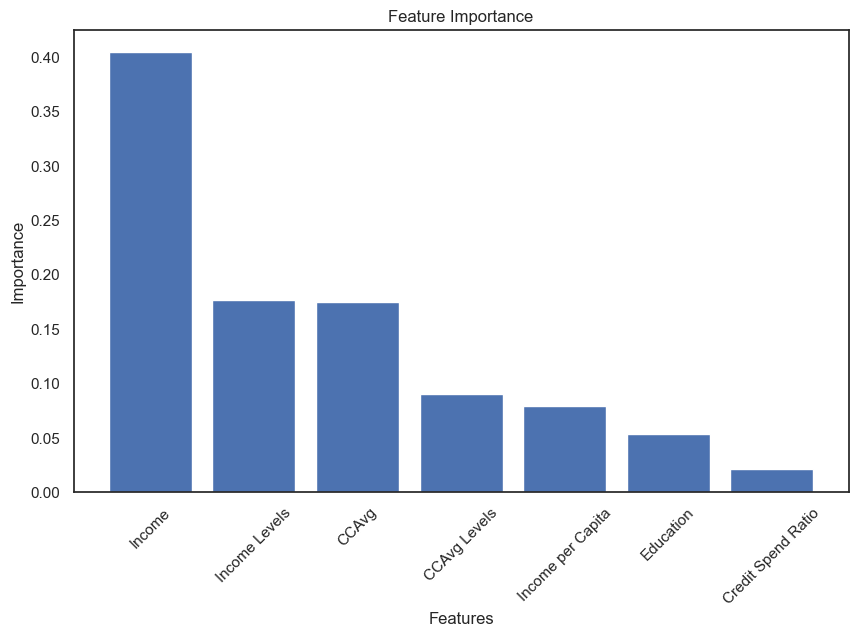

In [929]:
# Extract the best RF model from the pipeline
best_rf = random_search.best_estimator_.named_steps['rf']

# Get feature importances
importances = best_rf.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]

# Sort feature importances
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), np.array(feature_names)[indices], rotation=45)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()


The feature importance plot from the Random Forest provides a great overview of which variables are most influential in the model. To take this a step further, we can use partial dependence plots (PDPs) to visualize how each feature impacts the model’s predictions. PDPs will allow us to see the relationship between individual features and the target variable, helping us better understand the specific effects of key variables on loan acceptance likelihood. This insight can guide both model interpretation and decision-making.

413384.85s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
413384.85s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


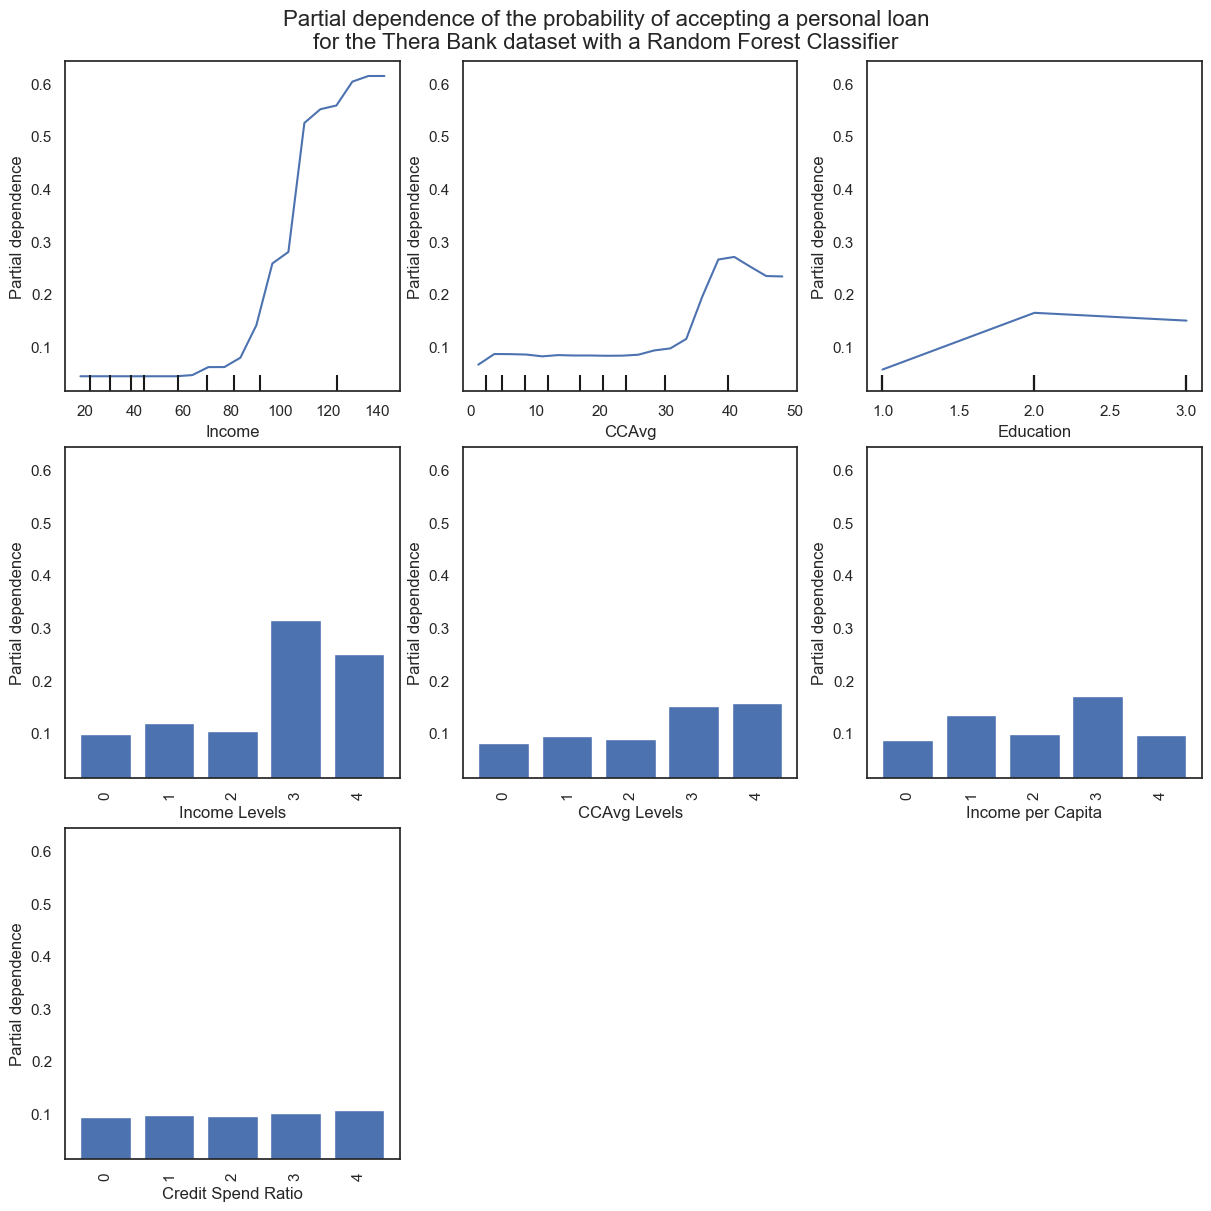

In [930]:
# Label categorical features for the model
categorical_features = ["Income Levels", "CCAvg Levels", "Income per Capita", "Credit Spend Ratio"]

common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

features_info = {
    # List features
    "features": ["Income", "CCAvg", "Education"] + categorical_features,
    # Use average plot
    "kind": "average",
    # Information regarding categorical features
    "categorical_features": categorical_features,
}

# Dynamically calculate grid size
num_features = len(features_info["features"])
ncols = 3
nrows = ceil(num_features / ncols)

# Create the grid
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows), constrained_layout=True)

# Flatten the axes
ax = ax.flatten()

# Remove any extra axes before passing them
for extra_ax in ax[num_features:]:
    extra_ax.remove()

# Generate Partial Dependence Plots
display = PartialDependenceDisplay.from_estimator(
    best_rf,
    X_test,
    **features_info,
    ax=ax[:num_features],  # Pass the required number of axes
    **common_params,
)

# Add title
_ = display.figure_.suptitle(
    "Partial dependence of the probability of accepting a personal loan\n"
    "for the Thera Bank dataset with a Random Forest Classifier",
    fontsize=16,
)
plt.xlim
# Show the plots
plt.show()


In [931]:
# Display intervals to aid analysis 

# Convert intervals to strings
bin_intervals_income_strings = bin_intervals_income.astype(str)
bin_intervals_CCAvg_strings = bin_intervals_CCAvg.astype(str)
bin_intervals_creditspendration_strings = bin_intervals_creditspendration.astype(str)
bin_intervals_incomepercapita_strings = bin_intervals_incomepercapita.astype(str)

# Create DataFrame
income = pd.DataFrame({
    "Income Intervals": bin_intervals_income_strings})
cc = pd.DataFrame({
    "CCAvg Intervals": bin_intervals_CCAvg_strings})
creditspend = pd.DataFrame({
    "Credit Spend Ratio Intervals": bin_intervals_creditspendration_strings})
percapita = pd.DataFrame({
    "Income per Capita Intervals": bin_intervals_incomepercapita_strings})
# Display the DataFrame
print(income)
print(cc)
print(creditspend)
print(percapita)


  Income Intervals
0    (7.999, 35.0]
1     (35.0, 83.0]
2    (83.0, 112.0]
3   (112.0, 134.0]
4   (134.0, 185.0]
               CCAvg Intervals
0  (0.009000000000000001, 7.2]
1                  (7.2, 26.4]
2                 (26.4, 33.6]
3                 (33.6, 44.4]
4                 (44.4, 62.4]
  Credit Spend Ratio Intervals
0               (0.666, 2.206]
1               (2.206, 6.333]
2              (6.333, 12.361]
3             (12.361, 25.885]
4            (25.885, 18300.0]
  Income per Capita Intervals
0               (1.999, 14.0]
1                (14.0, 45.0]
2                (45.0, 72.0]
3                (72.0, 91.0]
4               (91.0, 185.0]


**Analysis of the plots**

Continuous Features

Income
    The probability of loan acceptance shows two sharp, exponential increases. The first is for for high income individuals earning between 83.0 and 112.0. The second, and most predictive, is for individuals earning above 112.0.
    This suggests that higher income indivudals are far more likely to accept personal loans.

CCAvg
    The probability of loan acceptance remains relatively stable for lower values of CCAvg and starts to increase significantly after 33.6. This implies that individuals with higher credit card usage are more likely to accept a personal loan.

Education
    A small increase probability of loan acceptance is observed for education levels between 1.5 and 3.0, representing higher education categories. 

Discrete Features
    Across all categories we see that individuals with higher income are more likely to accept personal loans. 



Partial Dependence Plots (PDP) represent the average marginal effects of features by averaging the responses across all samples in the dataset. However, this averaging can sometimes obscure individual effects. To address this, we can plot Individual Conditional Expectation (ICE) plots, which display the responses for each individual sample. Below, we showcase 50 randomly selected ICE curves for the continuous features to provide a more detailed perspective.

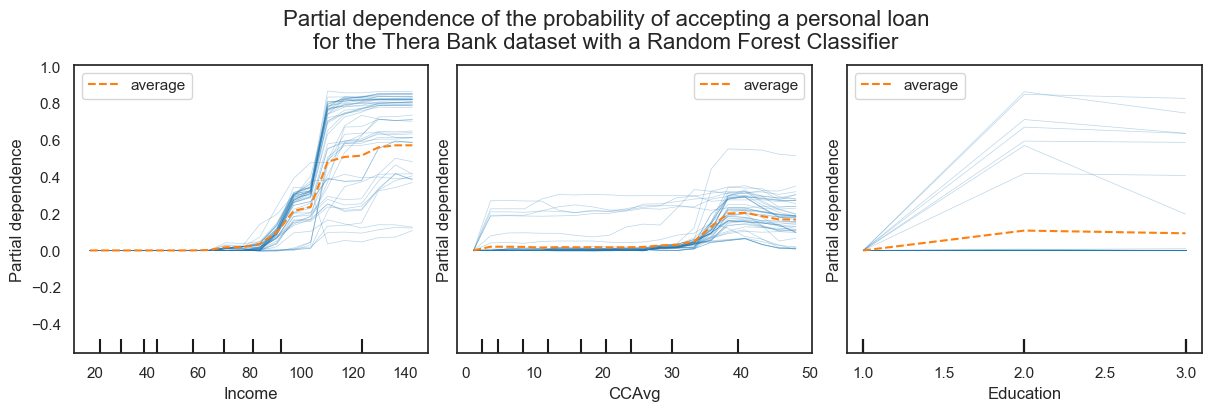

In [932]:
# Label categorical features for the model
categorical_features = ["Income Levels", "CCAvg Levels", "Income per Capita", "Credit Spend Ratio"]

common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

features_info = {
    # Features of interest
    "features": ["Income", "CCAvg", "Education"],
    # Type of partial dependence plot
    "kind": "both",
    "centered": True,
    # Information regarding categorical features
    "categorical_features": categorical_features,
}

# Dynamically calculate grid size
num_features = len(features_info["features"])
ncols = 3
nrows = ceil(num_features / ncols)

# Create the grid
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows),sharey=True, constrained_layout=True)

# Flatten the axes
ax = ax.flatten()

# Remove any extra axes before passing them
for extra_ax in ax[num_features:]:
    extra_ax.remove()

# Generate Partial Dependence Plots
display = PartialDependenceDisplay.from_estimator(
    best_rf,
    X_test,
    **features_info,
    ax=ax[:num_features],  # Pass only the required number of axes
    **common_params,
)

# Add a title to the figure
_ = display.figure_.suptitle(
    "Partial dependence of the probability of accepting a personal loan\n"
    "for the Thera Bank dataset with a Random Forest Classifier",
    fontsize=16,
)

# Customize plot
plt.legend()
plt.show()

# Show the plots
plt.show()


The ICE lines reveal a sharp increase in dependence for incomes above 112.6, with a significant proportion falling between 60% and 80%. This reinforces our conclusion that affluent individuals are the most likely to accept personal loans. Similarly, the ICE plots for CCAvg and Income offer no additional insights beyond this observation.

To finalize the PDP analysis, I will use a 2D interaction plot to explore how two features jointly impact the model’s predictions. This visualization helps uncover any interactions between variables that might influence loan acceptance, offering a deeper understanding of the model’s behavior beyond individual effects.

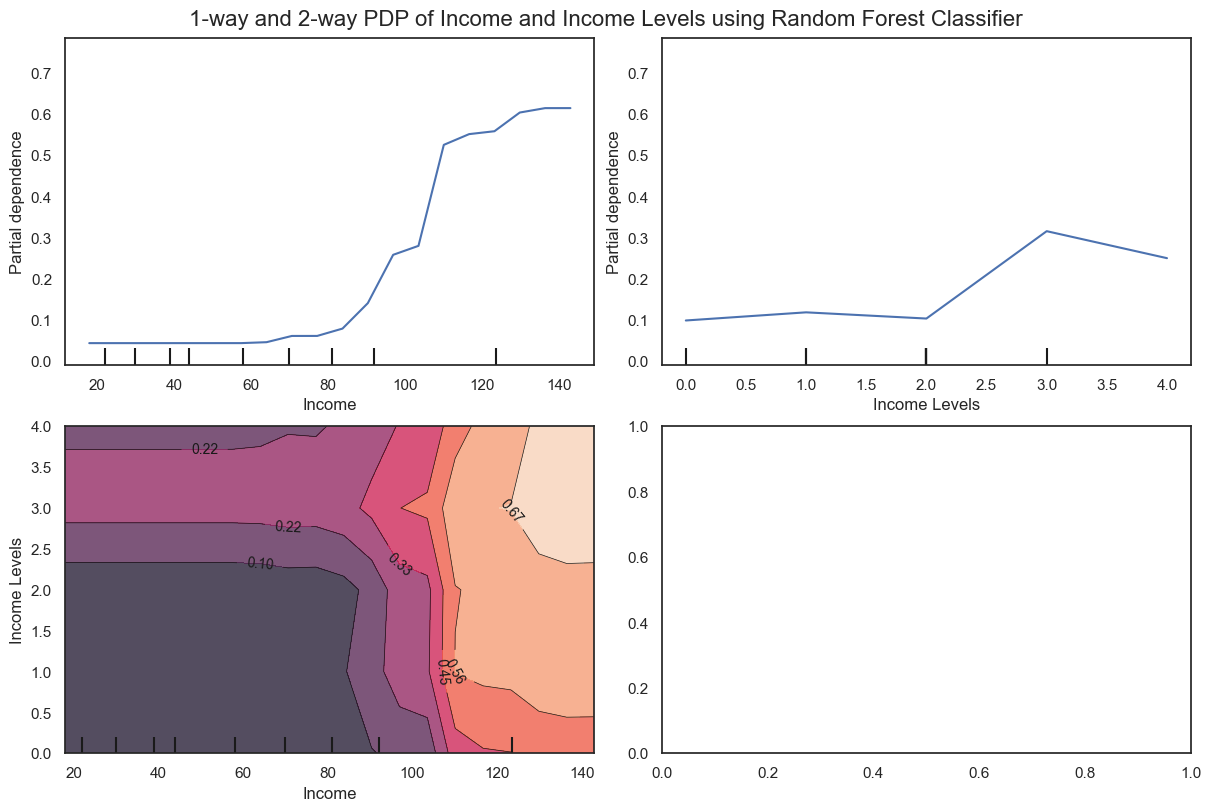

In [933]:
# Define model, data, and common parameters
common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

# Features for partial dependence plots
features = ["Income", "Income Levels", ("Income", "Income Levels")]

# Dynamically calculate grid size
num_features = len(features)
ncols = 2  # Number of columns in the grid
nrows = ceil(num_features / ncols)  # Calculate required rows

# Create the grid for subplots
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8), constrained_layout=True)
ax = ax.flatten()

# Generate Partial Dependence Plots
display = PartialDependenceDisplay.from_estimator(
    best_rf,  
    X_test,  
    features=features,
    kind="average",
    ax=ax[:num_features],  # Pass only the required number of axes
    **common_params,
)

# Add a title to the figure
_ = display.figure_.suptitle(
    "1-way and 2-way PDP of Income and Income Levels using Random Forest Classifier",
    fontsize=16,
)

# Show the plots
plt.show()


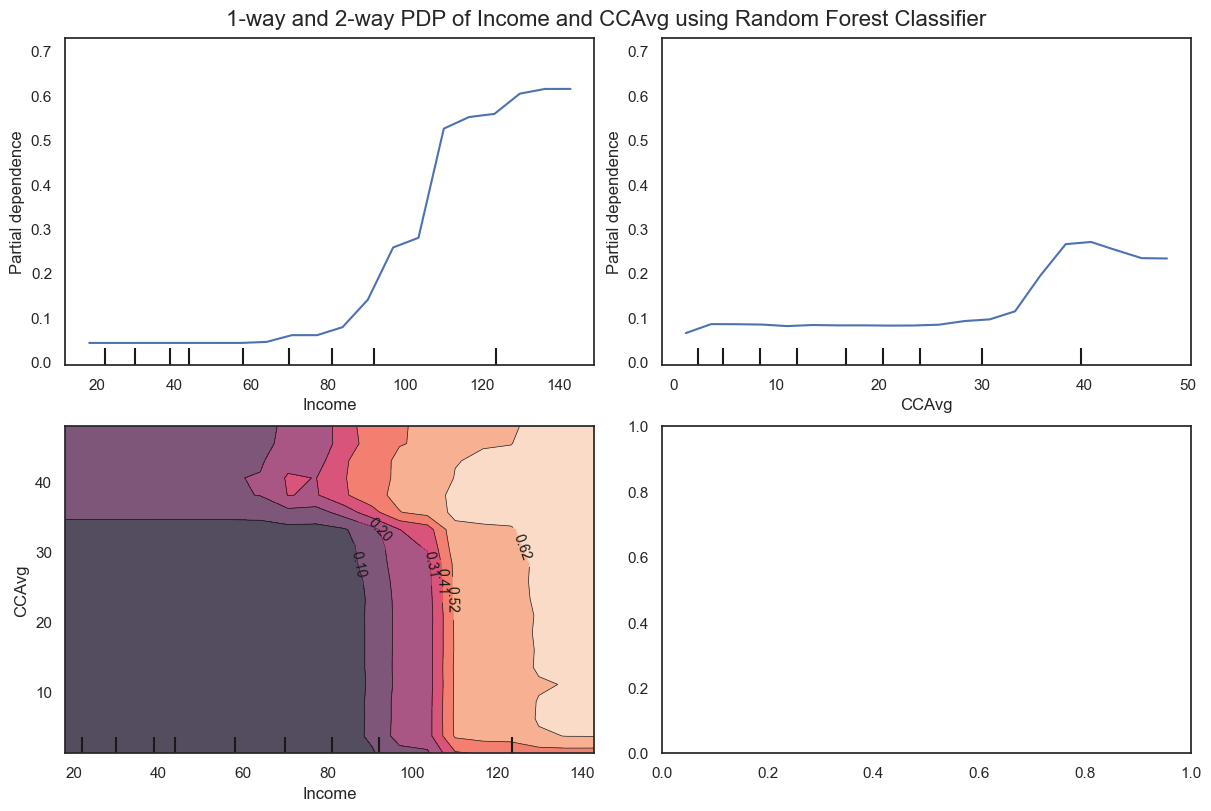

In [934]:
# Define model, data, and common parameters
common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

# Features for partial dependence plots
features = ["Income", "CCAvg", ("Income", "CCAvg")]

# Dynamically calculate grid size
num_features = len(features)
ncols = 2  # Number of columns in the grid
nrows = ceil(num_features / ncols)  # Calculate required rows

# Create the grid for subplots
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8), constrained_layout=True)
ax = ax.flatten()

# Generate Partial Dependence Plots
display = PartialDependenceDisplay.from_estimator(
    best_rf,  
    X_test,  
    features=features,
    kind="average",
    ax=ax[:num_features],  # Pass only the required number of axes
    **common_params,
)

# Add a title to the figure
_ = display.figure_.suptitle(
    "1-way and 2-way PDP of Income and CCAvg using Random Forest Classifier",
    fontsize=16,
)

# Show the plots
plt.show()


Both 2D interaction plots provide insighful information that will support our conclusion. 

**Conclusion**

1. Target affluent borrowers
    Focus marketing efforts on indiviudals earning above 112.0 in levels three and four. 
    Investigate primary usage of personal loans. 

2. Leverage credit card usage data
    Target individuals with high credit card usage (above 33.6).
    Investigate primary usage of personal loans.

3. Develop bespoke product offerings
    Leverage analysis of borrower behavior to increase success ratio of targeted marketing. 

**Areas for Improvement**

1. Using clustering-based methods during EDA would have streamlined the process by automatically grouping the data into meaningful subgroups. This approach would have eliminated the need to manually create bins and categories, allowing for more efficient and data-driven segmentation.

2. While there are additional methods available to further tune our model, I chose not to pursue them. In a realistic setting, achieving perfection isn’t always feasible or necessary. Instead, I focused on uncovering the key business insights, which I believe provide sufficient value for decision-making.